In [28]:
from cil.framework import DataContainer, BlockDataContainer, Partitioner

# Import libraries
  
from cil.optimisation.algorithms import SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, MixedL21Norm
 
from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
 
 
import numpy as np
import matplotlib.pyplot as plt
import os
from cil.framework import Sampler


In [29]:
reader = ZEISSDataReader()
filename = '../data/valnut_tomo-A.txrm'
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

#show2D(data)

In [30]:
import matplotlib
print(matplotlib. __version__)


3.5.0


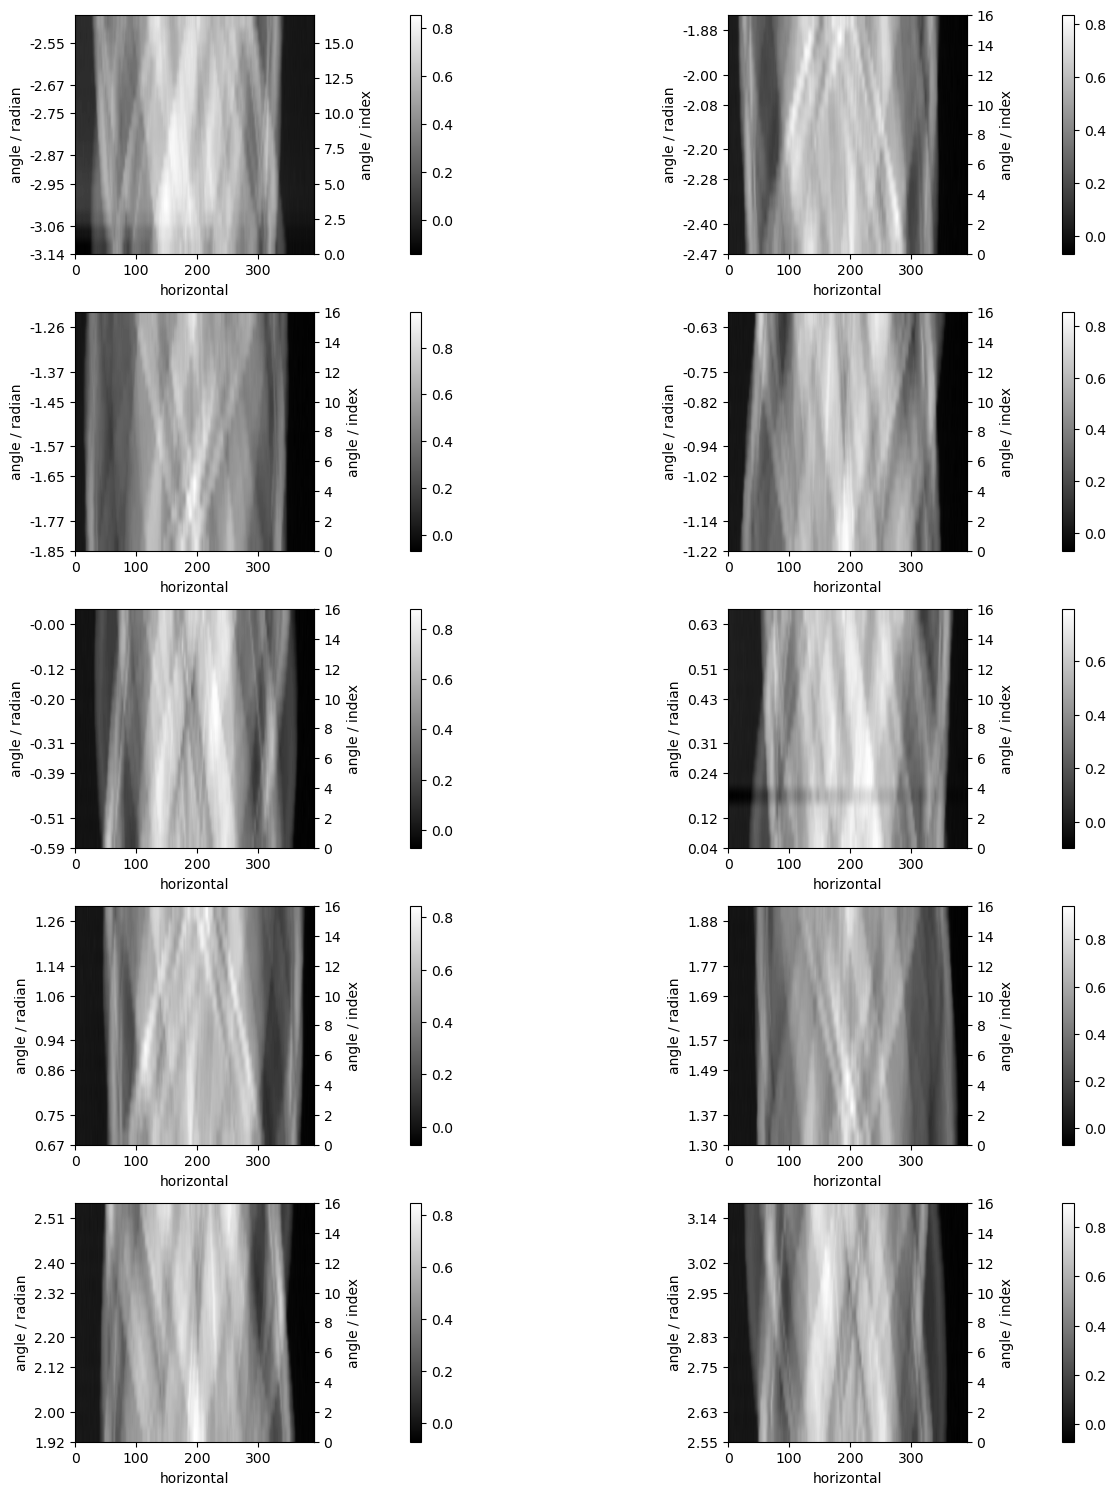

In [31]:
# Define number of subsets
n_subsets = 10

partitioned_data=data.partition(n_subsets, 'sequential')
show2D(partitioned_data)


# Initialize the lists containing the F_i's and A_i's
f_subsets = []


# Define F_i's 
for i in range(n_subsets):
    # Define F_i and put into list
    fi = 0.5*L2NormSquared(b = partitioned_data[i])
    f_subsets.append(fi)
    
    
ageom_subset = partitioned_data.geometry
A = ProjectionOperator(ig2D, ageom_subset)

#F = L2NormSquared.fromBlockDataContainer(partitioned_data, constant=0.5)

# Define F and K
F = BlockFunction(*f_subsets)
K = A

# Define G (by default the positivity constraint is on)
alpha = 0.025
G = alpha * FGP_TV()

In [32]:
print(ageom_subset)
print(A)
print(A.shape[0])

10


In [33]:
# Setup and run SPDHG for 50 iterations
spdhg_sequential = SPDHG(f = F, g = G, operator = K,  max_iteration = 300,
            update_objective_interval = 10, sampler=Sampler.sequential(n_subsets))
spdhg_sequential.run()

spdhg_recon = spdhg_sequential.solution    

/home/bih17925/miniconda3/envs/cil_testing/lib/python3.8/site-packages/cil/optimisation/algorithms/SPDHG.py:158: UserWarning: You supplied both probabilities and a sampler. The given probabilities will be ignored.
  warnings.warn('You supplied both probabilities and a sampler. The given probabilities will be ignored.')


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          6.90194e+03
       10        300         0.069          2.18689e+02
       20        300         0.066          6.31607e+01
       30        300         0.067          4.47907e+01
       40        300         0.066          3.92732e+01
       50        300         0.070          3.61163e+01
       60        300         0.069          3.44346e+01
       70        300         0.070          3.31590e+01
       80        300         0.070          3.19448e+01
       90        300         0.070          3.09544e+01
      100        300         0.076          3.02902e+01
      110        300         0.078          2.98881e+01
      120        300         0.077          2.96385e+01
      130        300         0.075          2.94481e+01
      140        300         0.074          2.92892e+01
      150        300         0.076          2.91

In [34]:
# Setup and run SPDHG for 50 iterations
spdhg_pert = SPDHG(f = F, g = G, operator = K,  max_iteration = 300,
            update_objective_interval = 10, sampler=Sampler.randomWithReplacement(n_subsets))
spdhg_pert.run()

spdhg_recon = spdhg_pert.solution    

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          6.90194e+03
       10        300         0.072          2.22196e+02
       20        300         0.067          1.01425e+02
       30        300         0.066          5.39193e+01
       40        300         0.066          4.12682e+01
       50        300         0.071          3.62349e+01
       60        300         0.071          3.69507e+01
       70        300         0.072          3.45206e+01
       80        300         0.073          3.33521e+01
       90        300         0.074          3.24880e+01
      100        300         0.075          3.13468e+01
      110        300         0.075          3.09067e+01
      120        300         0.075          3.02869e+01
      130        300         0.075          3.01021e+01
      140        300         0.074          2.99049e+01
      150        300         0.074          2.94

In [35]:
# Setup and run SPDHG for 50 iterations
spdhg_random = SPDHG(f = F, g = G, operator = K,  max_iteration = 300,
            update_objective_interval = 10 , sampler=Sampler.randomWithoutReplacement(n_subsets))
spdhg_random.run()

spdhg_recon = spdhg_random.solution    

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          6.90194e+03
       10        300         0.077          2.35489e+02
       20        300         0.076          6.68171e+01
       30        300         0.076          3.94409e+01
       40        300         0.073          3.92155e+01
       50        300         0.072          3.55872e+01
       60        300         0.070          3.42743e+01
       70        300         0.070          3.27740e+01
       80        300         0.070          3.16231e+01
       90        300         0.071          3.08240e+01
      100        300         0.071          2.99050e+01
      110        300         0.070          2.97330e+01
      120        300         0.070          2.94489e+01
      130        300         0.070          2.92444e+01
      140        300         0.070          2.91250e+01
      150        300         0.070          2.89

In [36]:
spdhg_hermanmeyer = SPDHG(f = F, g = G, operator = K,  max_iteration = 300,
            update_objective_interval = 10, sampler=Sampler.hermanMeyer(n_subsets))
spdhg_hermanmeyer.run()

spdhg_recon = spdhg_hermanmeyer.solution    

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          6.90194e+03
       10        300         0.056          2.68647e+02
       20        300         0.061          6.68233e+01
       30        300         0.064          4.48463e+01
       40        300         0.064          3.96950e+01
       50        300         0.065          3.65347e+01
       60        300         0.067          3.46603e+01
       70        300         0.070          3.32492e+01
       80        300         0.070          3.19492e+01
       90        300         0.070          3.09354e+01
      100        300         0.070          3.02728e+01
      110        300         0.072          2.98854e+01
      120        300         0.071          2.96441e+01
      130        300         0.071          2.94542e+01
      140        300         0.070          2.92922e+01
      150        300         0.070          2.91

In [37]:
spdhg_staggered = SPDHG(f = F, g = G, operator = K,  max_iteration = 300,
            update_objective_interval = 10, sampler=Sampler.staggered(n_subsets, 3))
spdhg_staggered.run()

spdhg_recon = spdhg_staggered.solution    

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          6.90194e+03
       10        300         0.062          1.78845e+02
       20        300         0.066          6.32034e+01
       30        300         0.066          4.62551e+01
       40        300         0.065          4.00518e+01
       50        300         0.071          3.67276e+01
       60        300         0.072          3.49012e+01
       70        300         0.071          3.34801e+01
       80        300         0.071          3.21938e+01
       90        300         0.073          3.11886e+01
      100        300         0.072          3.05335e+01
      110        300         0.072          3.01489e+01
      120        300         0.073          2.98994e+01
      130        300         0.072          2.96980e+01
      140        300         0.072          2.95209e+01
      150        300         0.072          2.93

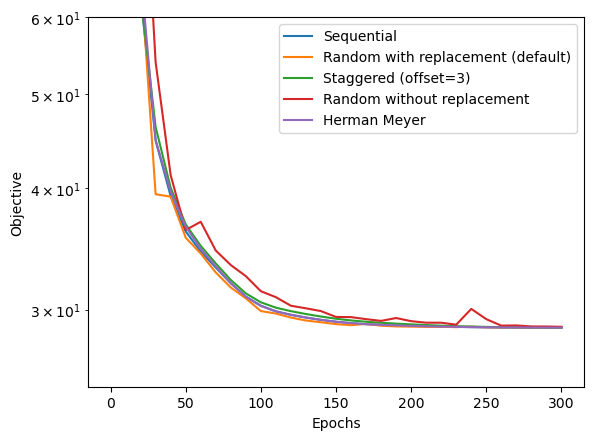

In [39]:
iter_range=range(0,301,10)
plt.figure()
plt.semilogy(iter_range, spdhg_sequential.objective, label='Sequential')
plt.semilogy(iter_range, spdhg_random.objective, label='Random with replacement (default)')
plt.semilogy(iter_range, spdhg_staggered.objective, label='Staggered (offset=3)')
plt.semilogy(iter_range, spdhg_pert.objective, label='Random without replacement')
plt.semilogy(iter_range, spdhg_hermanmeyer.objective, label='Herman Meyer')
plt.xlabel('Epochs')
plt.ylabel('Objective')
plt.ylim(25,60)
plt.legend()
plt.show()